In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import *

In [2]:
cnv="9:11857975-12047033_-"
name="9p23"

In [3]:
cmd=" ".join(["for f in $(find /oak/stanford/groups/mrivas/ukbb24983/cnv/gwas/",
              "-name '*.linear' -o -name '*.hybrid' | grep white_british);",
              "do",
              "phe=$(echo $f | awk -F'.' '{print $2}');"
              "awk -v p=$phe -v OFS='\\t' -v na='NA' -v g="+cnv,
              "'($NF < 0.01 && $3 == g && $NF !~ /na/){print p,$1,$2,$3,$4,$5,$6,$(NF-5),$(NF-4),$(NF-3),$(NF-2),$(NF-1),$NF}'",
              "$f;",
              "done",
              ">",
              "/oak/stanford/groups/jpriest/cnv_ukb/subanalyses/phewas/"+name+"_all_phewas_p001.tsv"
             ])
os.system(cmd)

0

In [29]:
phenos = pd.read_table("/oak/stanford/groups/jpriest/cnv_ukb/subanalyses/phewas/"+name+"_all_phewas_p001.tsv", 
                       usecols=[0,8,9,10,11,12],
                       names=["PHENO","N","BETA","SE","TSTAT","P"])
phenos.head()

,PHENO,N,BETA,SE,TSTAT,P
0,MED1140876146,333280,57.1784,1.46237,2.76686,0.005660
1,MED1140874138,333280,63.9620,1.46393,2.84049,0.004504
2,MED1140910498,333280,59.3287,1.47250,2.77291,0.005556
3,MED1140871266,333280,32.6955,1.04096,3.35001,0.000808
4,MED1140928004,333280,68.6783,1.46947,2.87821,0.003999


In [30]:
with open("/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt", "r") as i:
    names = {line.split()[0]:line.split()[2] for line in i if int(line.split()[1]) > 499}

phenos['BIN']  = phenos['PHENO'].apply(lambda x: 0 if 'QT' in x or 'INI' in x else 1)
phenos['BETA'] = phenos.apply(lambda row: np.log(row['BETA']) if row['BIN'] == 1 else row['BETA'], axis=1)
phenos['NAME'] = phenos['PHENO'].apply(lambda x: names.get(x) if x in names 
                                                 else names.get(x.replace('QT_FC', 'INI')) if x.replace('QT_FC','INI') in names 
                                                 else names.get(x.replace('BIN_FC','HC')) if x.replace('BIN_FC','HC') in names
                                                 else np.nan)
phenos.dropna(inplace=True)
phenos['-log10P'] = phenos['P'].apply(lambda x:-np.log10(x))

phenos.head()

,PHENO,N,BETA,SE,TSTAT,P,BIN,NAME,-log10P
8,INI5364,94110,0.853371,0.130457,6.54141,6.125380e-11,0,Average_weekly_intake_of_other_alcoholic_drinks,10.212867
20,MED1141182628,333280,2.959068,1.049190,2.82034,4.797310e-03,1,tiotropium,2.319002
80,MED1141168326,333280,3.408077,0.908812,3.75004,1.768100e-04,1,kliovance_1mg/0.5mg_tablet,3.752493
94,BIN_FC1006150,242195,2.407449,0.643912,3.73879,1.849070e-04,1,Vascular/heart_problems_diagnosed_by_doctor_He...,3.733047
117,QT_FC1001369,332217,0.664253,0.200951,3.30555,9.479950e-04,0,Beef_intake,3.023194


In [31]:
phenos[(phenos['P'] < 0.001)].sort_values('P').head(40)

,PHENO,N,BETA,SE,TSTAT,P,BIN,NAME,-log10P
8,INI5364,94110,0.853371,0.130457,6.54141,6.125380e-11,0,Average_weekly_intake_of_other_alcoholic_drinks,10.212867
211,HC326,333280,2.593522,0.566832,4.57547,4.751540e-06,1,heart_attack/myocardial_infarction,5.323166
194,RH3,333280,2.982900,0.668410,4.46268,8.094110e-06,1,Acute_Myocardial_Infarction,5.091831
80,MED1141168326,333280,3.408077,0.908812,3.75004,1.768100e-04,1,kliovance_1mg/0.5mg_tablet,3.752493
94,BIN_FC1006150,242195,2.407449,0.643912,3.73879,1.849070e-04,1,Vascular/heart_problems_diagnosed_by_doctor_He...,3.733047
223,HC107,333280,3.223079,0.906789,3.55439,3.788580e-04,1,miscarriage,3.421524
117,QT_FC1001369,332217,0.664253,0.200951,3.30555,9.479950e-04,0,Beef_intake,3.023194


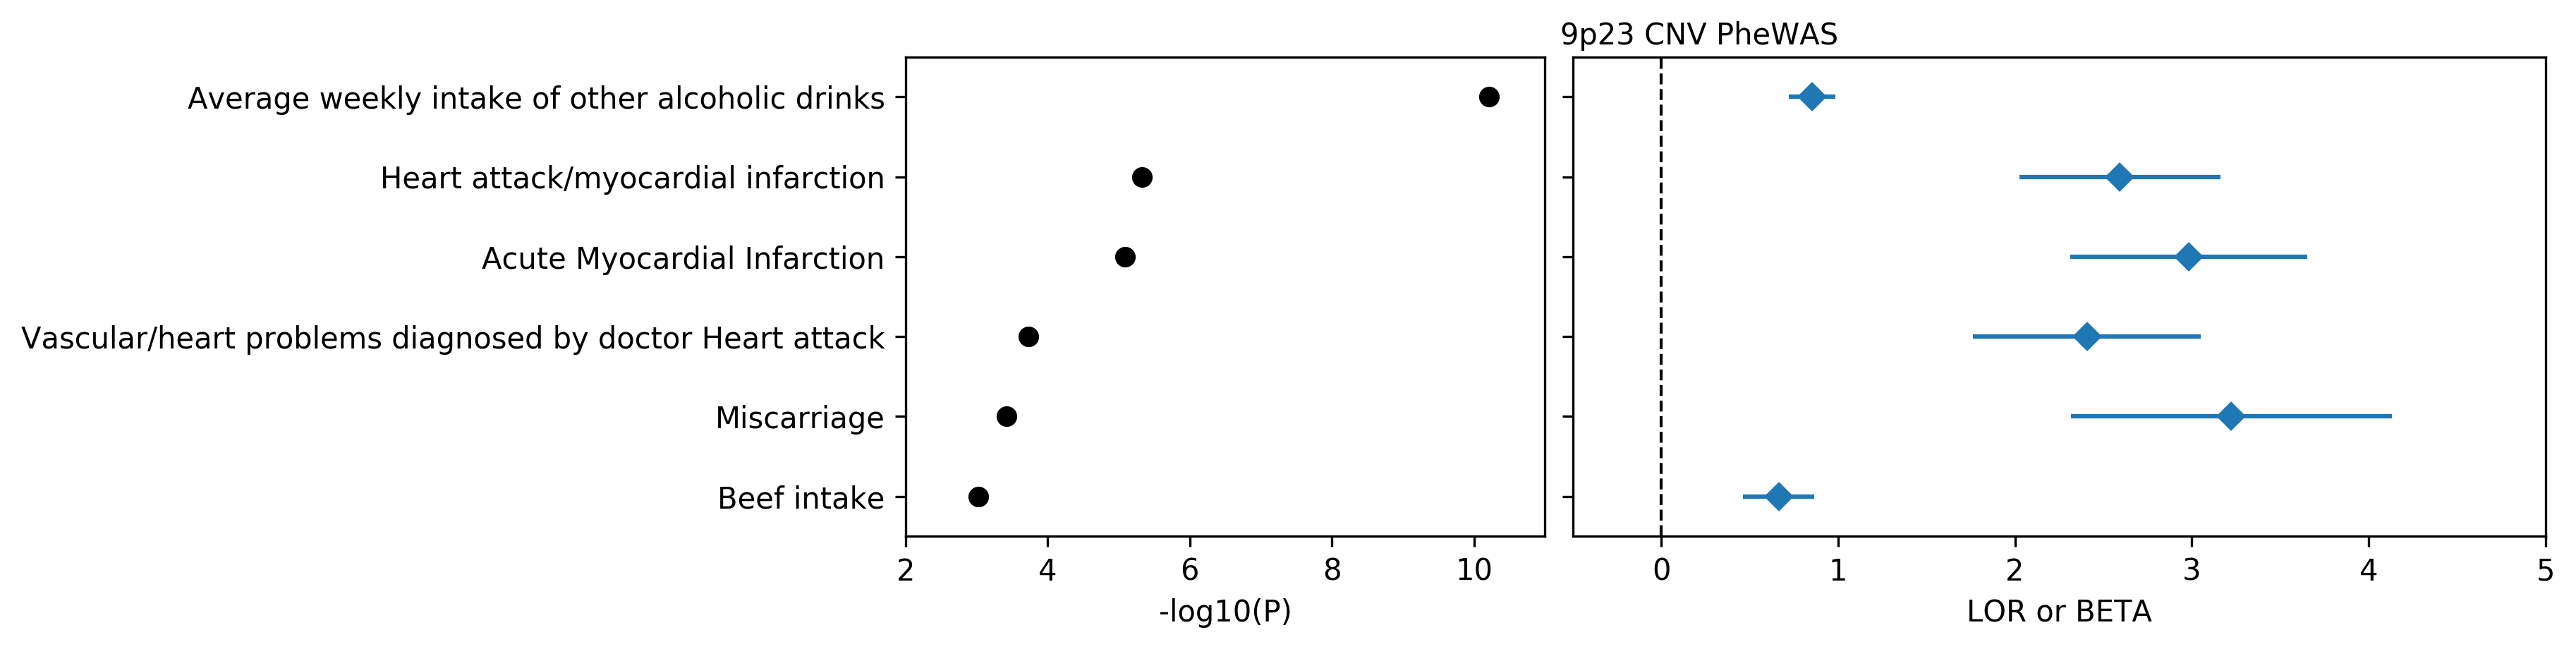

In [32]:
# do the plot
filter_kw = lambda s: all([i not in s for i in ['3mm','method']])

y_ht = 3
fig  = plt.figure(figsize=(10, y_ht), dpi=300)
grid = plt.GridSpec(y_ht, 10, hspace=0.3)


for cnv_ix, cnv in enumerate([name]):
    # select significant data, truncate visualization
    data = phenos.loc[(~phenos['NAME'].isnull()) & 
                      (phenos['NAME'].apply(filter_kw)) & 
                      (phenos['PHENO'].apply(lambda s:'MED' not in s))].query('P < 1e-3').copy()
    
    # remove phenotypes with high (1) standard error, truncate number of phenotypes at 50
    data = data.query('SE < 2').sort_values('P').head(50).copy()
    # group by QT/BIN status
    order = [irow[0] for irow in sorted([irow for irow in data.iterrows()], 
                                         key=lambda (i,x): -x['P'] + 0*x['BIN'])] 

    # title
    fig.text(0.5, 0.9, cnv + ' CNV PheWAS', horizontalalignment='center')
    
    # p-values
    ax = fig.add_subplot(grid[:,:4])
    ax.plot([data.loc[i,'-log10P'] for i in order], list(range(len(order))), 'ko')
    ax.set_ylim(-0.5,len(order)-0.5)
    ax.set_yticks(list(range(len(order)))) 
    ax.set_yticklabels(list(map(lambda s:s[0].upper() + s[1:].replace('_',' '), [data.loc[i,'NAME'] for i in order])))
    ax.set_xlabel('-log10(P)')
    ax.set_xlim(2,11)

    # betas
    ax = fig.add_subplot(grid[:,4:])
    ax.errorbar(x=[data.loc[i,'BETA'] for i in order], 
                y=list(range(len(order))),
                xerr=[data.loc[i,'SE'] for i in order],
                linestyle='', marker='D')
    ax.set_ylim(-0.5,len(order)-0.5)
    ax.set_yticks(list(range(len(order))))
    ax.set_yticklabels(['' for _ in order])
    ax.set_xlabel('LOR or BETA')
    ax.set_xlim(-0.5,5)
    ax.yaxis.set_label_position("right")

    # dash line for betas
    plt.plot([0,0], ax.get_ylim(), 'k--', linewidth=1)

plt.show()